In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pytreenet as ptn
import random
from numpy.random import default_rng
from pytreenet.random import random_tensor_node
from fractions import Fraction
import matplotlib.pyplot as plt
import math

# Test of different tree structure on Effective Lattice Hamiltonian
In the main manuscript one set of the experiments is about testing different tree structures over a lattice hamiltonian given as follow::
$$

H = \sum_{i,j} \frac{J}{\|i - j\|} X_i X_j + \sum_i g Z_i
$$

We here implemented different tree structures in the first part and run an experiment with increased grid size in the second part.

## Part I: Construction of different tree structures and Hamiltonian

First of all, create different tree structures described in the manuscript with figure 8:

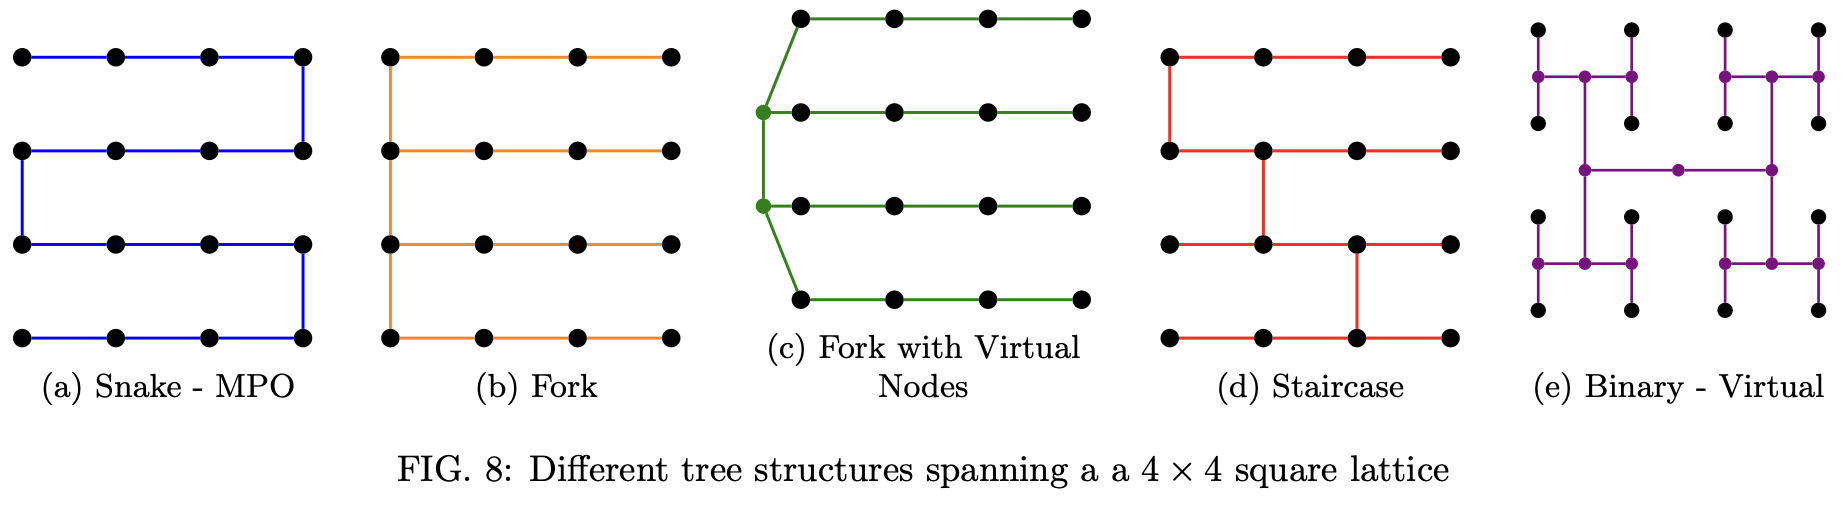

In [3]:
def construct_snake_like_tree(L: int) -> ptn.TreeTensorNetworkState:
    """
    Constructs a tree structure for an LxL grid where the grid is connected
    linearly in a snake-like pattern.
    
    Args:
        L (int): The size of the grid (LxL).
    
    Returns:
        ptn.TreeTensorNetworkState: The resulting tree tensor network state.
    """
    ttns = ptn.TreeTensorNetworkState()
    debug = False
    
    # Helper to create tensor nodes
    def create_node(identifier, shape):
        return random_tensor_node(shape, identifier=identifier)

    # Generate the grid as a snake-like traversal
    nodes = {}
    tensors = {}

    # Create nodes for the grid
    total_sites = L * L
    last_node = total_sites - 1 if L % 2 == 1 else total_sites - L
    for i in range(total_sites):
        site_id = f"site{i + 1}"
        if i == 0:  # Root node (only one child)
            node, tensor = create_node(site_id, (1, 2))
        elif i == last_node: # Last row (only one parent)  
            node, tensor = create_node(site_id, (1, 2))
        else:  # Intermediate nodes (one parent, one child)
            node, tensor = create_node(site_id, (1, 1, 2))
        nodes[site_id] = node
        tensors[site_id] = tensor

    # Add root (first site in the grid)
    root_site = "site1"
    ttns.add_root(nodes[root_site], tensors[root_site])

    # Connect the grid linearly in a snake-like pattern
    prev_site = root_site
    for i in range(L):
        row_sites = [f"site{L * i + j + 1}" for j in range(L)]
        if i % 2 == 1:  # Reverse the row for even-indexed rows (snake pattern)
            row_sites = row_sites[::-1]
        for site in row_sites:
            if site != prev_site:  # Skip the root
                # Use different child-parent indices for root and intermediate nodes
                if prev_site == root_site:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 0)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")
                else:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 1)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")
                prev_site = site

    return ttns

In [4]:
def construct_layered_tree(L: int) -> ptn.TreeTensorNetworkState:
    """
    Constructs a tree structure for an LxL grid where rows are connected sequentially,
    and the first element of each row connects to the each other.

    Args:
        L (int): The size of the grid (LxL).

    Returns:
        ptn.TreeTensorNetworkState: The resulting tree tensor network state.
    """
    ttns = ptn.TreeTensorNetworkState()
    debug = False

    # Helper to create tensor nodes with appropriate shape
    def create_node(identifier, shape):
        return random_tensor_node(shape, identifier=identifier)

    # Generate the grid
    nodes = {}
    tensors = {}

    # Create nodes for the grid
    total_sites = L * L
    for i in range(total_sites):
        site_id = f"site{i + 1}"
        if i == 0:  # Root node (only one child)
            node, tensor = create_node(site_id, (1, 1, 2))
        elif i % L == 0:  # First element of a new row (one parent, two child)
            if i == total_sites - L:
                node, tensor = create_node(site_id, (1, 1, 2))
            else:
                node, tensor = create_node(site_id, (1, 1, 1, 2))
        elif i % L == L - 1:  # Last node (only one parent)
            node, tensor = create_node(site_id, (1, 2))
        else:  # Intermediate nodes (one parent, one child)
            node, tensor = create_node(site_id, (1, 1, 2))
        nodes[site_id] = node
        tensors[site_id] = tensor

    # Add root (site 1)
    root_site = "site1"
    ttns.add_root(nodes[root_site], tensors[root_site])

    # Connect the tree as per the layered structure
    prev_site = root_site
    for i in range(L):
        if prev_site != root_site:
            prev_site = f"site{L * (i-1) + 1}"
        row_sites = [f"site{L * i + j + 1}" for j in range(L)]

        for site_idx, site in enumerate(row_sites):
            if site_idx == 0 and i > 0:  # Connect the first element of the row to the last element of the previous row
                if prev_site == root_site:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 1)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")

                else:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 2)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")

            elif site_idx > 0:  # Connect elements sequentially within the row
                if prev_site == root_site:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 0)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")

                else:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 1)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")

            else:
                continue
            prev_site = site

    return ttns

In [5]:
def construct_staircase_tree(L: int) -> ptn.TreeTensorNetworkState:
    """
    Constructs a tree structure for an LxL grid where nodes connected in a diagonal way.

    Args:
        L (int): The size of the grid (LxL).

    Returns:
        ptn.TreeTensorNetworkState: The resulting tree tensor network state.
    """
    ttns = ptn.TreeTensorNetworkState()
    debug = False

    # Helper to create tensor nodes with appropriate shape
    def create_node(identifier, shape):
        return random_tensor_node(shape, identifier=identifier)

    # Generate the grid
    nodes = {}
    tensors = {}

    # Create nodes for the grid
    total_sites = L * L
    for i in range(total_sites):
        site_id = f"site{i + 1}"
        
        if i % L == L-1:  # Last in a row
            node, tensor = create_node(site_id, (1, 2))
            if debug: print(f"site{i+1} : shape: {tensor.shape}")
        elif i % L == 0 and i >= 2*L :  # First in a row
            node, tensor = create_node(site_id, (1, 2))
            if debug: print(f"site{i+1} : shape: {tensor.shape}")
        elif (i // L  == i % L or i // L == i % L + 1 ) and i // L > 0 and i % L > 0 and i % L < L-1: # staircase nodes 
                node, tensor = create_node(site_id, (1, 1, 1, 2))
                if debug: print(f"site{i+1} : shape: {tensor.shape}")
        else:  # Intermediate nodes 
            node, tensor = create_node(site_id, (1, 1, 2))
            if debug: print(f"site{i+1} : shape: {tensor.shape}")
        nodes[site_id] = node
        tensors[site_id] = tensor

    # Add root (site 1)
    root_site = "site1"
    ttns.add_root(nodes[root_site], tensors[root_site])
    queue = [root_site]

    # Connect the tree as per the staircase structure
    while len(queue) > 0:
        
        current_node = queue.pop(0)
        current_row = (int(current_node[4:])-1) // L
        current_col = (int(current_node[4:])-1) % L
        vacant_dim = 1
        if current_node == root_site:
            vacant_dim = 0
        if debug: print(f"current_node: {current_node}, current_row: {current_row}, current_col: {current_col}")

        if current_col == current_row:
            if current_row < L-1:
                next_node = f"site{L*(current_row+1) + current_col+1}"
                
                ttns.add_child_to_parent(nodes[next_node], tensors[next_node], 0, current_node, vacant_dim)
                vacant_dim += 1
                queue.append(next_node)
            if current_col < L-1:
                next_node = f"site{L*current_row + current_col+2}"
                
                ttns.add_child_to_parent(nodes[next_node], tensors[next_node], 0, current_node, vacant_dim)
                vacant_dim += 1
                queue.append(next_node)
        elif current_row == current_col + 1:
            if current_col < L-1:
                next_node = f"site{L*current_row + current_col+2}"
                ttns.add_child_to_parent(nodes[next_node], tensors[next_node], 0, current_node, vacant_dim)
                vacant_dim += 1 
                queue.append(next_node)
            if current_col > 0:
                next_node = f"site{L*current_row + current_col}"
                ttns.add_child_to_parent(nodes[next_node], tensors[next_node], 0, current_node, vacant_dim)
                vacant_dim += 1
                queue.append(next_node)
            
        elif current_row < current_col :
            if current_col < L-1:
                next_node = f"site{L*current_row + current_col+2}"
                ttns.add_child_to_parent(nodes[next_node], tensors[next_node], 0, current_node, vacant_dim)
                vacant_dim += 1
                queue.append(next_node)
        elif current_row > current_col:
            if current_col > 0:
                next_node = f"site{L*current_row + current_col}"
                ttns.add_child_to_parent(nodes[next_node], tensors[next_node], 0, current_node, vacant_dim)
                vacant_dim += 1
                queue.append(next_node)
    

    return ttns

In [6]:
def construct_binary_tree(L: int) -> ptn.TreeTensorNetworkState:
    """
    Constructs a tree structure for an LxL grid with virtual nodes that forms a binary tree. Here we create nodes in a snake traverse
    and connect them in a binary tree structure.

    Args:
        L (int): The size of the grid (LxL).

    Returns:
        ptn.TreeTensorNetworkState: The resulting tree tensor network state.
    """
    ttns = ptn.TreeTensorNetworkState()
    debug = False

    # Helper to create tensor nodes with appropriate shape
    def create_node(identifier, shape):
        return random_tensor_node(shape, identifier=identifier)

    # Generate the grid
    nodes = {}
    tensors = {}

    # Create nodes for the grid
    total_sites = L * L
    for i in range(total_sites):
        site_id = f"site{i + 1}"
        node, tensor = create_node(site_id, (1, 2))
        nodes[site_id] = node
        tensors[site_id] = tensor
    
    # Create virtual nodes on the road

    G = L**2
    
    D_base = math.floor(math.log2(G))
    v_count = G - 1 # Comes from:  (2 ** D_base - 1) + (G - 2 ** D_base)

    process_list = []
    for i in range(1, L + 1):
        if i % 2 == 1:
            # Odd row: left to right
            process_list.extend(range((i - 1) * L + 1, i * L + 1))
        else:
            # Even row: right to left
            process_list.extend(range(i * L, (i - 1) * L, -1))
    next_process = 2*(G - 2**D_base)

    # Add root (site 1)
    root_site = "sitev1"
    node_v, tensor_v = create_node(root_site, (1, 1))
    ttns.add_root(node_v, tensor_v)
    i = 1
    queue = [root_site]

    while queue:
        current_site = queue.pop(0) 
        vacant_dim = 1
        if current_site == root_site:
            vacant_dim = 0
        
        for _ in range(2):
            if i < v_count :
                next_site = f"sitev{i + 1}"
                node_v, tensor_v = create_node(next_site, (1, 1, 1))
                ttns.add_child_to_parent(node_v, tensor_v, 0, current_site, vacant_dim)
                if debug: print(f"Parent {current_site} connected to Child {next_site}")
                vacant_dim += 1
                queue.append(next_site)
            else:
                next_site = f"site{process_list[next_process]}"
                next_process = (next_process + 1) % G
                
                ttns.add_child_to_parent(nodes[next_site], tensors[next_site], 0, current_site, vacant_dim)
                if debug: print(f"Parent {current_site} connected to Child {next_site}")
                vacant_dim += 1
        
            i += 1
        
    return ttns

In [7]:
def construct_binary_tree_alt(L: int) -> ptn.TreeTensorNetworkState:
    """
    Constructs a tree structure for an LxL grid with virtual nodes that forms a binary tree. Here we create nodes in a snake traverse
    and connect them in a binary tree structure.

    Args:
        L (int): The size of the grid (LxL).

    Returns:
        ptn.TreeTensorNetworkState: The resulting tree tensor network state.
    """
    ttns = ptn.TreeTensorNetworkState()
    debug = False

    # Helper to create tensor nodes with appropriate shape
    def create_node(identifier, shape):
        return random_tensor_node(shape, identifier=identifier)

    # Generate the grid
    nodes = {}
    tensors = {}

    # Create nodes for the grid
    total_sites = L * L
    for i in range(total_sites):
        site_id = f"site{i + 1}"
        node, tensor = create_node(site_id, (1, 2))
        nodes[site_id] = node
        tensors[site_id] = tensor
    
    # Create virtual nodes on the road

    G = L**2
    
    D_base = math.floor(math.log2(G))
    v_count = G - 1 # Comes from:  (2 ** D_base - 1) + (G - 2 ** D_base)

    process_list = list(range(1, G + 1))
    random.shuffle(process_list)
    next_process = 2*(G - 2**D_base)

    # Add root (site 1)
    root_site = "sitev1"
    node_v, tensor_v = create_node(root_site, (1, 1))
    ttns.add_root(node_v, tensor_v)
    i = 1
    queue = [root_site]

    while queue:
        current_site = queue.pop(0) 
        vacant_dim = 1
        if current_site == root_site:
            vacant_dim = 0
        
        for _ in range(2):
            if i < v_count :
                next_site = f"sitev{i + 1}"
                node_v, tensor_v = create_node(next_site, (1, 1, 1))
                ttns.add_child_to_parent(node_v, tensor_v, 0, current_site, vacant_dim)
                if debug: print(f"Parent {current_site} connected to Child {next_site}")
                vacant_dim += 1
                queue.append(next_site)
            else:
                next_site = f"site{process_list[next_process]}"
                next_process = (next_process + 1) % G
                
                ttns.add_child_to_parent(nodes[next_site], tensors[next_site], 0, current_site, vacant_dim)
                if debug: print(f"Parent {current_site} connected to Child {next_site}")
                vacant_dim += 1
        
            i += 1
        
    return ttns

In [8]:
def construct_layered_tree_with_virtual_nodes(L: int) -> ptn.TreeTensorNetworkState:
    """
    Constructs a tree structure for an LxL grid with virtual nodes that group rows hierarchically.

    Args:
        L (int): The size of the grid (LxL).

    Returns:
        ptn.TreeTensorNetworkState: The resulting tree tensor network state.
    """
    ttns = ptn.TreeTensorNetworkState()
    debug = False

    # Helper to create tensor nodes with appropriate shape
    def create_node(identifier, shape):
        return random_tensor_node(shape, identifier=identifier)

    # Generate the grid
    nodes = {}
    tensors = {}

    # Create physical nodes for the grid
    total_sites = L * L
    for i in range(total_sites):
        site_id = f"site{i + 1}"
          
        if i % L == L - 1:  # Last node (only one parent)
            node, tensor = create_node(site_id, (1, 2))
        else:  # Intermediate nodes (one parent, one child)
            node, tensor = create_node(site_id, (1, 1, 2))
        nodes[site_id] = node
        tensors[site_id] = tensor

    # Create virtual nodes for each layer
    
    for i in range(1,L-1):
        virtual_id = f"virtual{i + 1}"
        node, tensor = create_node(virtual_id, (1, 1, 1)) 
        nodes[virtual_id] = node
        tensors[virtual_id] = tensor

    # Add root (site1) and connect to the first virtual node
    root_site = "site1"
    ttns.add_root(nodes[root_site], tensors[root_site])
    prev_site = root_site

    if L == 2:
        ttns.add_child_to_parent(nodes["site2"], tensors["site2"], 0, "site1", 0)
        ttns.add_child_to_parent(nodes["site3"], tensors["site3"], 0, "site1", 1)
        ttns.add_child_to_parent(nodes["site4"], tensors["site4"], 0, "site3", 1)
        return ttns


    # Connect the tree using virtual nodes
    for i in range(L):
        
        row_sites = [f"site{L * i + j + 1}" for j in range(L)]
        virtual_id = f"virtual{i + 1}"

        if i > 0 and i < L-1:
            if i == 1:
                ttns.add_child_to_parent(nodes[virtual_id], tensors[virtual_id], 0, f"site{L * (i-1) + 1}", 1)
                if debug: print(f"parent site{L * (i-1) + 1} connected to site {virtual_id}")
            else: 
                ttns.add_child_to_parent(nodes[virtual_id], tensors[virtual_id], 0, f"virtual{i}", 2)
                if debug: print(f"parent virtual{i} connected to Child {virtual_id}")
            
            ttns.add_child_to_parent(nodes[f"site{L * (i) + 1}"], tensors[f"site{L * (i) + 1}"], 0, virtual_id, 1)
            if debug: print(f"parent {virtual_id} connected to child  site{L * (i) + 1} ")

            if i == L-2:
                ttns.add_child_to_parent(nodes[f"site{L * (i+1) + 1}"], tensors[f"site{L * (i+1) + 1}"], 0,virtual_id , 2)
                if debug: print(f"parent {virtual_id}  connected to site site{L * (i+1) + 1}")


        for site_idx, site in enumerate(row_sites):
            if site_idx > 0: 
                
                if prev_site == root_site:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 0)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")
                else:
                    ttns.add_child_to_parent(nodes[site], tensors[site], 0, prev_site, 1)
                    if debug: print(f"Parent {prev_site} connected to Child {site}")
            
            prev_site = site
            

    return ttns


Then we need to create the hamiltonian. Hamiltonian creation depends on the three arguments:
L = Length of the grid
J = Interaction coefficient
g = Field coefficient


In [9]:
def generate_grid(L):
    """Generate a grid of LxL sites and return a mapping from (x, y) to site labels."""
    grid = {}
    for x in range(L):
        for y in range(L):
            grid[(x, y)] = f"site{L * x + y + 1}"  # Label sites sequentially
    return grid

# Calculate Manhattan distance
def hamiltonian_distance(site1, site2, grid):
    """Compute Manhattan distance between two grid points."""
    coords = {v: k for k, v in grid.items()}  # Reverse mapping
    x1, y1 = coords[site1]
    x2, y2 = coords[site2]
    return abs(x1 - x2) + abs(y1 - y2)

def generate_hamiltonian(L, J, g):
    """Generate a symbolic Hamiltonian for an LxL grid."""
    grid = generate_grid(L)
    ham = []
    coeffs = []

    # Interaction term: J / ||i - j|| * X_i X_j
    for idx1, site1 in enumerate(grid.values()):
        for idx2, site2 in enumerate(grid.values()):
            if idx1 < idx2:  # Ensure unique pairs (i < j)
                distance = hamiltonian_distance(site1, site2, grid)
                term = {s: "I2" for s in grid.values()}  # Identity everywhere
                term[site1] = "X"
                term[site2] = "X"
                ham.append((Fraction(1, distance), "J", term))


    # Local field term: g * Z_i
    for site in grid.values():
        term = {s: "I2" for s in grid.values()}  # Identity everywhere
        term[site] = "Z"
        ham.append( (Fraction(1, 1), "g", term) )

    # Coefficient mapping
    coeffs_mapping = {"1": 1, "J": J, "g": g}

    return ham, coeffs_mapping


In [11]:
def construct_hamiltonian(ham, coeffs_mapping) -> ptn.Hamiltonian:
    
    paulis = ptn.pauli_matrices()
    conversion_dict = {"X": paulis[0], "Y": paulis[1], "Z": paulis[2], "I2": np.eye(2), "I1": np.eye(1)}
    return ptn.Hamiltonian([(frac,coeff,ptn.TensorProduct(term)) for frac,coeff,term in ham], conversion_dictionary=conversion_dict, coeffs_mapping=coeffs_mapping)


Now we can create an example TTNO with any tree structure and grid size and verify its correctness

In [12]:
L = 2
J = 1
g = 1

In [14]:
ham, coeffs_mapping = generate_hamiltonian(L, J, g)

ttns_layered = construct_layered_tree(L)
#ttns_snake = construct_snake_like_tree(L)
#ttns_layered_v = construct_layered_tree_with_virtual_nodes(L)
#ttns_staircase = construct_staircase_tree(L)
#ttns_binary = construct_binary_tree(L)

hamiltonian = construct_hamiltonian(ham, coeffs_mapping)
hamiltonian_padded = hamiltonian.pad_with_identities(ttns_layered)

#ttns_virt = construct_reference_tree_virtual()

[(Fraction(1, 1), 'J', {'site1': 'X', 'site2': 'X', 'site3': 'I2', 'site4': 'I2'}), (Fraction(1, 1), 'J', {'site1': 'X', 'site2': 'I2', 'site3': 'X', 'site4': 'I2'}), (Fraction(1, 2), 'J', {'site1': 'X', 'site2': 'I2', 'site3': 'I2', 'site4': 'X'}), (Fraction(1, 2), 'J', {'site1': 'I2', 'site2': 'X', 'site3': 'X', 'site4': 'I2'}), (Fraction(1, 1), 'J', {'site1': 'I2', 'site2': 'X', 'site3': 'I2', 'site4': 'X'}), (Fraction(1, 1), 'J', {'site1': 'I2', 'site2': 'I2', 'site3': 'X', 'site4': 'X'}), (Fraction(1, 1), 'g', {'site1': 'Z', 'site2': 'I2', 'site3': 'I2', 'site4': 'I2'}), (Fraction(1, 1), 'g', {'site1': 'I2', 'site2': 'Z', 'site3': 'I2', 'site4': 'I2'}), (Fraction(1, 1), 'g', {'site1': 'I2', 'site2': 'I2', 'site3': 'Z', 'site4': 'I2'}), (Fraction(1, 1), 'g', {'site1': 'I2', 'site2': 'I2', 'site3': 'I2', 'site4': 'Z'})]


### Terms of the hamiltonian

In [22]:
for i, term in enumerate(hamiltonian_padded.terms):
    single_term_diag = ptn.SingleTermDiagram.from_single_term(term, ttns_layered)
    print(f"State Diagram for term {i}")
    print(single_term_diag)

State Diagram for term 0
Hyperedges: {'site1': 'X (1 * J)', 'site2': 'X (1 * 1)', 'site3': 'I2 (1 * 1)', 'site4': 'I2 (1 * 1)'}
Vertices: [('site1', 'site2'), ('site1', 'site3'), ('site3', 'site4')]
State Diagram for term 1
Hyperedges: {'site1': 'X (1 * J)', 'site2': 'I2 (1 * 1)', 'site3': 'X (1 * 1)', 'site4': 'I2 (1 * 1)'}
Vertices: [('site1', 'site2'), ('site1', 'site3'), ('site3', 'site4')]
State Diagram for term 2
Hyperedges: {'site1': 'X (1/2 * J)', 'site2': 'I2 (1 * 1)', 'site3': 'I2 (1 * 1)', 'site4': 'X (1 * 1)'}
Vertices: [('site1', 'site2'), ('site1', 'site3'), ('site3', 'site4')]
State Diagram for term 3
Hyperedges: {'site1': 'I2 (1/2 * J)', 'site2': 'X (1 * 1)', 'site3': 'X (1 * 1)', 'site4': 'I2 (1 * 1)'}
Vertices: [('site1', 'site2'), ('site1', 'site3'), ('site3', 'site4')]
State Diagram for term 4
Hyperedges: {'site1': 'I2 (1 * J)', 'site2': 'X (1 * 1)', 'site3': 'I2 (1 * 1)', 'site4': 'X (1 * 1)'}
Vertices: [('site1', 'site2'), ('site1', 'site3'), ('site3', 'site4')]
S

### Complete State Diagram

In [23]:
state_diagram1 = ptn.StateDiagram.from_hamiltonian(hamiltonian_padded, ttns_layered, ptn.state_diagram.TTNOFinder.SGE)
print(len(state_diagram1.get_all_vertices()))
print(state_diagram1)

10
hyperedges:
label = X; corr_site = site1; coeff = 1 * J; connected to ('site1', 'site2'), ('site1', 'site3'), 
label = X; corr_site = site1; coeff = 1 * J; connected to ('site1', 'site2'), ('site1', 'site3'), 
label = I2; corr_site = site1; coeff = 1/2 * J; connected to ('site1', 'site2'), ('site1', 'site3'), 
label = I2; corr_site = site1; coeff = 1 * 1; connected to ('site1', 'site2'), ('site1', 'site3'), 
label = Z; corr_site = site1; coeff = 1 * g; connected to ('site1', 'site2'), ('site1', 'site3'), 
label = I2; corr_site = site1; coeff = 1 * g; connected to ('site1', 'site2'), ('site1', 'site3'), 
label = X; corr_site = site1; coeff = 1/2 * J; connected to ('site1', 'site2'), ('site1', 'site3'), 
label = I2; corr_site = site1; coeff = 1 * J; connected to ('site1', 'site2'), ('site1', 'site3'), 
label = X; corr_site = site2; coeff = 1 * 1; connected to ('site1', 'site2'), 
label = I2; corr_site = site2; coeff = 1 * 1; connected to ('site1', 'site2'), 
label = Z; corr_site = sit

## PART II: Experiment

In this second section, we are going to run all tree structures with same hamiltonians and plot the results.

In [14]:
def obtain_bond_dimensions(ttno: ptn.TTNO) -> np.ndarray:
    """
    Obtains the bond dimensions of a TTN.

    Args:
        ttno (ptn.TTNO): The TTN for which to determine the bond dimensions.

    Returns:
        np.ndarray: A 1D-array containing all bond-dimensions
    """
    dimensions = []
    for node_id in ttno.nodes:
        node = ttno.nodes[node_id]
        if not node.is_root():
            dimensions.append(node.parent_leg_dim())

    if dimensions == []:
        return np.asarray([1])
    return np.asarray(dimensions)

In [ ]:
rng = default_rng(seed=421142)

L_values = np.arange(1, 11)

ttns_structures = [
    construct_snake_like_tree, 
    construct_layered_tree,   
    construct_layered_tree_with_virtual_nodes,
    construct_staircase_tree,
    construct_binary_tree
]
ttns_names = ["MPO Case Snake Like Tree", "Layered Tree", "Layered Tree with Virtual Nodes", "Staircase Tree", "Binary Tree with Virtual Nodes"] # Add names corresponding to ttn_structures

# Collecting mean and max bond dimensions for each TTN structure
results_mean = {name: [] for name in ttns_names}
results_max = {name: [] for name in ttns_names}
results_raw = {name: [] for name in ttns_names}

for L in L_values:
    J, g = rng.uniform(-2, 2, 2)
    
    hamiltonian = construct_hamiltonian(*generate_hamiltonian(L, J, g))
    
    for name, ttn_func in zip(ttns_names, ttns_structures):
        ttns = ttn_func(L)  # Generate TTN structure

        hamiltonian_process = hamiltonian.pad_with_identities(ttns)

        ttno = ptn.TTNO.from_hamiltonian(hamiltonian_process, ttns, method=ptn.state_diagram.TTNOFinder.SGE)  # Generate TTNO from Hamiltonian
        bond_dimensions = obtain_bond_dimensions(ttno)
        
        # Collect mean and max bond dimensions
        results_raw[name].append(bond_dimensions)
        results_mean[name].append(np.mean(bond_dimensions))
        results_max[name].append(np.max(bond_dimensions))    
                                              
    print("Grid size: ", L, " is done.")
        

Let's print out the results of the experiments:

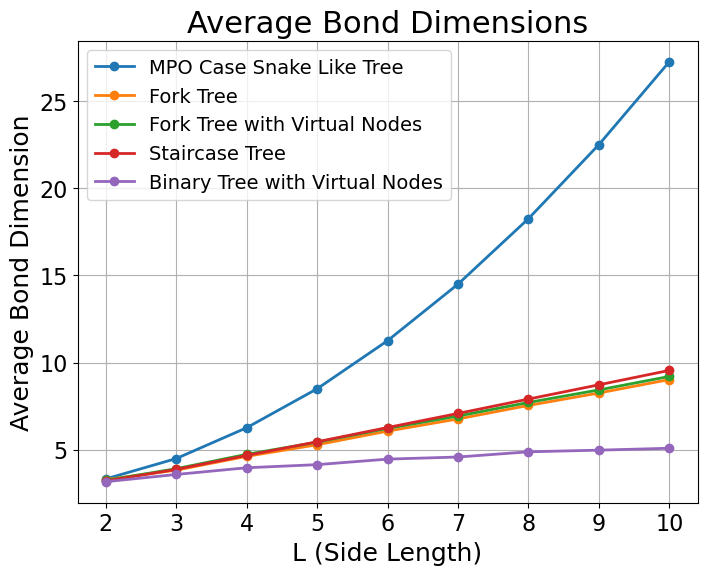

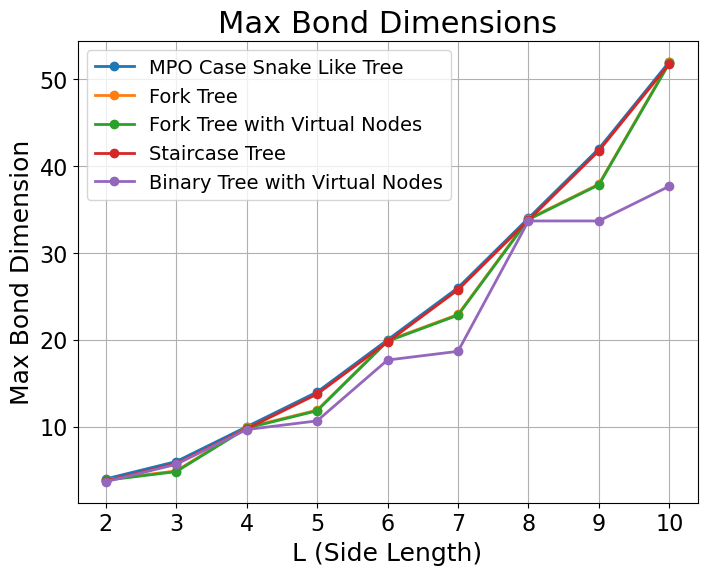

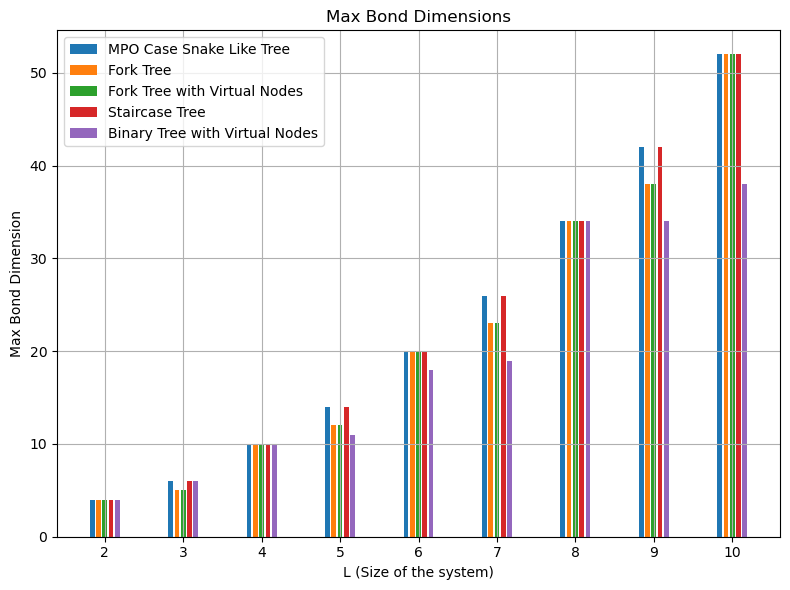

In [5]:
plt.figure(figsize=(8, 6))
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'X', '<', '>']
L_values = np.arange(2, 11)

# Mean bond dimensions

for i,name in enumerate(ttns_names):
    results = [x - i*0.04 for x in results_mean[name]]
    plt.plot(L_values, results, label=name, marker='o', linewidth=2)
plt.title("Average Bond Dimensions", fontsize=22)
plt.xlabel("L (Side Length)", fontsize=18)
plt.ylabel("Average Bond Dimension", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.savefig("./mean_results.pdf", format="pdf", bbox_inches="tight")



plt.figure(figsize=(8, 6))
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'X', '<', '>']


# Max bond dimensions

for i,name in enumerate(ttns_names):
    results = [x - i*0.08 for x in results_max[name]]

    plt.plot(L_values,results , label=name, marker='o', linestyle='-', linewidth=2)
plt.title("Max Bond Dimensions", fontsize=22)
plt.xlabel("L (Side Length)", fontsize=18)
plt.ylabel("Max Bond Dimension", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.savefig("./max_results.pdf", format="pdf", bbox_inches="tight")



# Max bond dimensions
plt.figure(figsize=(8, 6))
bar_width = 0.08
x_positions = np.arange(len(L_values))
for i, name in enumerate(ttns_names):
    offset = i * bar_width
    plt.bar(x_positions + offset, results_max[name], width=bar_width-0.02, label=name)
plt.xticks(x_positions + bar_width * (len(ttns_names) - 1) / 2, L_values)

    
plt.title("Max Bond Dimensions")
plt.xlabel("L (Size of the system)")
plt.ylabel("Max Bond Dimension")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig("./max_results_bar.pdf", format="pdf", bbox_inches="tight")


### Helper functions:

Use the following function to merge two different run of experiments. As bigger grid takes more time to compute, one might want to divide the experimentation of the different grid sizes for different trials.

In [ ]:
# Assuming results_mean, results_max, and results_raw correspond to first part of the grid sizes
# and results_mean_additional, results_max_additional, and results_raw_additional correspond to further addition.

def merge_dictionaries(dict1, dict2):
    """
    Merges two dictionaries by concatenating lists of matching keys.

    Args:
        dict1 (dict): The first dictionary to merge.
        dict2 (dict): The second dictionary to merge.

    Returns:
        dict: A merged dictionary with concatenated lists.
    """
    merged_dict = {}
    for key in dict1:
        # Concatenate lists from both dictionaries
        merged_dict[key] = dict1[key] + dict2[key]
    return merged_dict

# Merge the mean, max, and raw dictionaries
results_combined_mean = merge_dictionaries(results_mean, results_mean_additional)
results_combined_max = merge_dictionaries(results_max, results_max_additional)
results_combined_raw = merge_dictionaries(results_raw, results_raw_additional)

# Verify merging
print("Combined Mean Results:", results_combined_mean)
print("Combined Max Results:", results_combined_max)
print("Combined Raw Results:", results_combined_raw)
